In [5]:
#import the API and getpass
from arcgis.gis import GIS
from arcgis.features import FeatureLayer
from getpass import getpass
import pandas as pd
import requests

#authenticate with your account (create a free one here: https://www.arcgis.com/home/createaccount.html)
gis = GIS("https://www.arcgis.com", "astrong_pnw", getpass())
print(gis)

········
GIS @ https://pnw.maps.arcgis.com


In [52]:
#Spreadsheet works: https://opendata.arcgis.com/datasets/ca7680fe3a734c6684c4b6f48e07548e_0.csv
#so just download this read it in pandas then upload it back up,,, should work 
# -*- coding: utf-8 -*-
url = 'https://opendata.arcgis.com/datasets/ca7680fe3a734c6684c4b6f48e07548e_0.csv'

#download csv from url and encode utf-8
with requests.Session() as s:
    download = s.get(url)
    download_decoded = download.content.decode('utf-8')

#write downloaded csv to file
f = open('data.csv', 'w', encoding='utf-8')
f.write(download_decoded)
f.close
print("csv downloaded")

csv downloaded


In [53]:
#now we can read this with pandas 
data = 'data.csv'
df = pd.read_csv(data)

df[:5]

,X,Y,GISOBJID,OBJ_CODE,OWNER,POLE_TYPE,COLOR,LAMP_TYPE,WATTAGE,FIXTURE,PLAN_NO,SERVICE_NO,COMMISSION_DATE,OBJECTID,ESRI_OID
0,-121.495857,38.678290,100043389,SLT-37281,DOT,ORN,YES,HPS,100.0,NaN,E-3527A,1643,2012-01-31T00:00:00.000Z,37281,4001
1,-121.496072,38.677849,100043018,SLT-37283,DOT,ORN,YES,HPS,100.0,NaN,E-3527A,1643,2012-01-31T00:00:00.000Z,37283,4002
2,-121.495849,38.677562,100043019,SLT-37284,DOT,ORN,YES,HPS,100.0,NaN,E-3527A,1643,2012-01-31T00:00:00.000Z,37284,4003
3,-121.495643,38.677119,100043020,SLT-37285,DOT,ORN,YES,HPS,100.0,NaN,E-3527A,1643,2012-01-31T00:00:00.000Z,37285,4004
4,-121.498325,38.676328,100043021,SLT-37286,DOT,ORN,YES,HPS,100.0,NaN,E-3527A,1643,2012-01-31T00:00:00.000Z,37286,4005


In [54]:
#Can we calculate energy consumption by total wats? http://www.lightsearch.com/resources/lightguides/formulas.html
watt = df['WATTAGE']
watt = pd.to_numeric(watt, errors='coerce')

#Get KwH from Watts (A kilowatt-hour is 1,000 watts used for one hour)
kw = watt/1000
kw[:5]

0    0.1
1    0.1
2    0.1
3    0.1
4    0.1
Name: WATTAGE, dtype: float64

In [55]:
#now we can calculate KwH. Assuming these lights run 9 hours a day, 365 days a year we times each kw by 3285 to get kwh per year
#energy consumption and cost is typically based on kwh
kwh = kw * 3285
kwh[:5]

0    328.5
1    328.5
2    328.5
3    328.5
4    328.5
Name: WATTAGE, dtype: float64

In [56]:
#Typical cost in US per kwh is $.12 (calculate cost per year)
cost = kwh *.12
cost[:5]

0    39.42
1    39.42
2    39.42
3    39.42
4    39.42
Name: WATTAGE, dtype: float64

In [57]:
#add new fields
df['kwh'] = kwh
df['cost'] = cost
df[:5]

,X,Y,GISOBJID,OBJ_CODE,OWNER,POLE_TYPE,COLOR,LAMP_TYPE,WATTAGE,FIXTURE,PLAN_NO,SERVICE_NO,COMMISSION_DATE,OBJECTID,ESRI_OID,kwh,cost
0,-121.495857,38.678290,100043389,SLT-37281,DOT,ORN,YES,HPS,100.0,NaN,E-3527A,1643,2012-01-31T00:00:00.000Z,37281,4001,328.5,39.42
1,-121.496072,38.677849,100043018,SLT-37283,DOT,ORN,YES,HPS,100.0,NaN,E-3527A,1643,2012-01-31T00:00:00.000Z,37283,4002,328.5,39.42
2,-121.495849,38.677562,100043019,SLT-37284,DOT,ORN,YES,HPS,100.0,NaN,E-3527A,1643,2012-01-31T00:00:00.000Z,37284,4003,328.5,39.42
3,-121.495643,38.677119,100043020,SLT-37285,DOT,ORN,YES,HPS,100.0,NaN,E-3527A,1643,2012-01-31T00:00:00.000Z,37285,4004,328.5,39.42
4,-121.498325,38.676328,100043021,SLT-37286,DOT,ORN,YES,HPS,100.0,NaN,E-3527A,1643,2012-01-31T00:00:00.000Z,37286,4005,328.5,39.42


In [58]:
#let's add this to our account with the python api 
df.to_csv('lights_kwh_and_cost.csv', index=False)
new_data = 'lights_kwh_and_cost.csv'
item_prop = {'title':'Sac Streetlights KwH and Cost', 'type': 'CSV'}
csv_item = gis.content.add(item_prop, new_data)
print(f"item added to {gis}")

#publish
csv_item.publish()
print(f"item published to {gis}")

item added to GIS @ https://pnw.maps.arcgis.com
item published to GIS @ https://pnw.maps.arcgis.com


In [ ]:
#Let's search for the new item we just published and assign it to a variable
lights = gis.content.search(query='title:Sac Streetlights KwH and Cost AND type:Feature Service')
sac_lights = lights[0]
sac_lights

<Item title:"Light Cost!" type:Web Map owner:astrong_pnw>
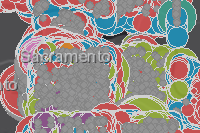

In [26]:
#now let's take a look at a pre cooked map of the streetlight cost data
lights_cost = gis.content.search(query='title:Light Cost!')
Sac_Streetlights_cost = lights_cost[0]
Sac_Streetlights_cost

In [59]:
#add sac neighborhoods layer to map http://data.cityofsacramento.org/datasets/neighborhoods
m = gis.map('Sacramento', zoomlevel=14)

#grab another open data set (neighborhoods)
neighborhoods = gis.content.get('49f20f1612ae4f0a9292eb65f8bd4013')
m.add_layer(neighborhoods)
m

In [60]:
#add sac lights layer
m.add_layer(sac_lights)

In [61]:
#select only those where cost > 1000
high_cost_df = df[df['cost'] > 100]
high_cost_df[:5]

,X,Y,GISOBJID,OBJ_CODE,OWNER,POLE_TYPE,COLOR,LAMP_TYPE,WATTAGE,FIXTURE,PLAN_NO,SERVICE_NO,COMMISSION_DATE,OBJECTID,ESRI_OID,kwh,cost
1004,-121.482260,38.557153,100017334,SLT-15083,DOT,MA,NO,HPS,400.0,NaN,E-0070,114,2012-01-23T00:00:00.000Z,15083,5005,1314.0,157.68
1722,-121.528211,38.500732,100010972,SLT-15945,DOT,PT,YES,HPS,400.0,NaN,E-1401,671,2012-01-23T00:00:00.000Z,15945,5723,1314.0,157.68
2752,-121.499210,38.577949,100020229,SLT-31868,DOT,MA,NO,HPS,400.0,NaN,E-1055,109,2012-01-23T00:00:00.000Z,31868,12753,1314.0,157.68
2805,-121.515424,38.560137,100021683,SLT-18891,PARKS,NaN,NO,MV,400.0,NaN,E-1363A,1182,2012-01-23T00:00:00.000Z,18891,12806,1314.0,157.68
4307,-121.502991,38.579326,100018571,SLT-30397,DOT,MA,STL,LED,400.0,NaN,E-1053B,383,2012-01-23T00:00:00.000Z,30397,308,1314.0,157.68


In [62]:
#add new df to ArcGIS Online
high_cost_df.to_csv('high_cost_streetlights.csv', index=False)
new_data = 'high_cost_streetlights.csv'
item_prop = {'title':'Sacramento High Cost Streetlights', 'type': 'CSV'}
csv_item = gis.content.add(item_prop, new_data)
print(f"item added to {gis}")

#publish
csv_item.publish()
print(f"item published to {gis}")

item added to GIS @ https://pnw.maps.arcgis.com
item published to GIS @ https://pnw.maps.arcgis.com


In [63]:
hcs = gis.content.search(query='title:Sacramento High Cost Streetlights AND type:Feature Service')
high_cost_lights = hcs[0]
high_cost_lights

<Item title:"High Cost Streetlights 2" type:Feature Layer Collection owner:astrong_pnw>

In [65]:
#Let's intersect this data with the City of Sacramento Neighborhoods layer: http://data.cityofsacramento.org/datasets/neighborhoods
from arcgis.features.analysis import aggregate_points

#grab neighborhoods data 
neighborhoods = gis.content.get('49f20f1612ae4f0a9292eb65f8bd4013')

high_cost_lights_by_nh = aggregate_points(high_cost_lights, neighborhoods, output_name="Sacramento High Cost Lights by Neighborhood")

# set sharing on new analysis layer
high_cost_lights_by_nh.share(True)


{'itemId': '14abaf3b0b194ce9ba84957c43560b41', 'notSharedWith': []}

In [66]:
high_cost_lights_by_nh

<Item title:"High Cost Lights by Neighborhood 2" type:Feature Layer Collection owner:astrong_pnw>

In [67]:
#Query analysis item directly using pandas 
from arcgis.features import FeatureLayer

feature_layer = FeatureLayer.fromitem(high_cost_lights_by_nh)
features = feature_layer.query()

#open features in pandas data frame 
analysis_df = features.df
analysis_df.sort_values('Point_Count', ascending=False)[:20]

,AnalysisArea,NAME,OBJECTID,Point_Count,Shape__Area,Shape__Length,SHAPE
62,0.828882,Downtown,63,33,2.310568e+07,20197.486592,"{'rings': [[[6705642.02289601, 1974935.4641605..."
72,1.083772,Upper Land Park,73,12,3.021108e+07,25624.829675,"{'rings': [[[6701211.71843642, 1959610.2979605..."
61,0.217843,Old Sacramento,62,6,6.072532e+06,15427.330725,"{'rings': [[[6703758.12016776, 1975096.9015017..."
113,5.464037,Meadowview,114,5,1.523191e+08,53592.790278,"{'rings': [[[6715073.80127651, 1935055.3306664..."
60,3.357815,East Sacramento,61,3,9.360171e+07,44584.503812,"{'rings': [[[6727071.72314675, 1962974.1481882..."
75,1.029512,Curtis Park,76,3,2.869860e+07,22397.694715,"{'rings': [[[6710259.79285993, 1966271.2039300..."
106,1.603746,Greenhaven,107,2,4.470656e+07,29110.458883,"{'rings': [[[6698486.895474, 1951754.63552234]..."
112,2.145427,Parkway,113,1,5.980716e+07,46837.515946,"{'rings': [[[6727986.8286, 1935115.86893117], ..."
12,0.354726,Pell/Main Industrial Park,13,1,9.888021e+06,19055.553641,"{'rings': [[[6711652.89702909, 2001705.5221689..."
92,0.453077,Little Pocket,93,1,1.263005e+07,15782.830360,"{'rings': [[[6698486.895474, 1951754.63552234]..."
